In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from preprocessing_modules import create_time_windows_with_labels
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE


/home/nwertheim/miniconda3/bin/python
/home/nwertheim/miniconda3/bin/python


In [13]:
'''MY DATA'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_old_train_old.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_old_test_old.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



744
192
{'record_name': 'Hopper-2024_09_17_06_51_03-0000010009-0001-chan0', 'signal': array([[ -5.57103828],
       [-11.39992724],
       [ -9.53483775],
       ...,
       [  0.73235611],
       [ -0.1656677 ],
       [  1.35035514]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 3360
  Preterm (1): 5748

Test label distribution:
  Term (0): 390
  Preterm (1): 2322
torch.Size([9108])


In [4]:



# Load the pre-trained encoder
path = os.path.join(models_path, 'FCMAE_encoder_no_PCA_gpu.pth')

# Load the full FCMAE model
fcmae = FCMAE(in_channels=1, base_dim=128, num_blocks=5, kernel_size=9)


# Load the saved weights into the full model
state_dict = torch.load(path)
fcmae.load_state_dict(state_dict)

# Extract only the encoder from the FCMAE model
encoder = fcmae.encoder
# Set the encoder to evaluation mode and freeze the encoder parameters
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False  # Freeze the encoder

print(encoder)

Sequential(
  (0): Conv1d(1, 128, kernel_size=(9,), stride=(2,), padding=(4,))
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(4,))
  (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv1d(256, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv1d(512, 1024, kernel_size=(9,), stride=(2,), padding=(4,))
  (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv1d(1024, 2048, kernel_size=(9,), stride=(2,), padding=(4,))
  (13): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
)


In [5]:
'''OUTPUT SHAPE ENCODER'''
# dummy_input = torch.randn(4, 1, 12000)  # (batch_size, channels, sequence_length)
# with torch.no_grad():
#     encoded = encoder(dummy_input)
# print(encoded.shape)


'OUTPUT SHAPE ENCODER'

epoch,train_loss,valid_loss,accuracy,time
0,0.676273,0.645973,0.782448,00:05
1,0.649226,0.644532,0.685472,00:05
2,0.639446,0.648177,0.709071,00:05
3,0.635012,0.627703,0.718289,00:05
4,0.629630,0.659110,0.664823,00:05
5,0.634151,0.631717,0.707965,00:05


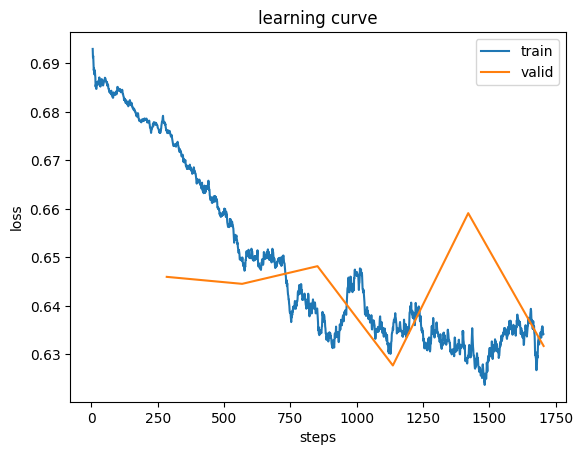

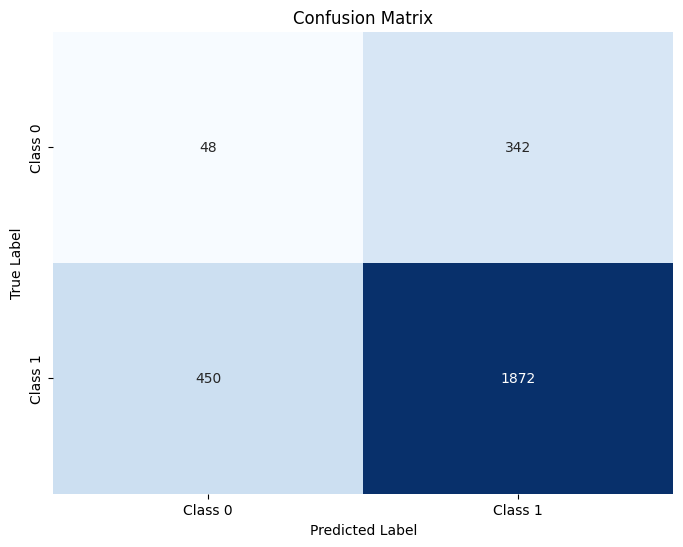

Accuracy: 0.7080
Precision: 0.8455
Recall: 0.8062
F1 Score: 0.8254
Average Precision (AP): 0.9473
Area Under ROC Curve (AUC): 0.7227


In [10]:
from tsai.models.ResNet import ResNet
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(2048, 2)  # 2048 channels from encoder, 2 output classes

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0 
)

model = FCMAEClassifier(encoder)
model.to(device)

learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(6, 1e-6)

learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")



epoch,train_loss,valid_loss,accuracy,time


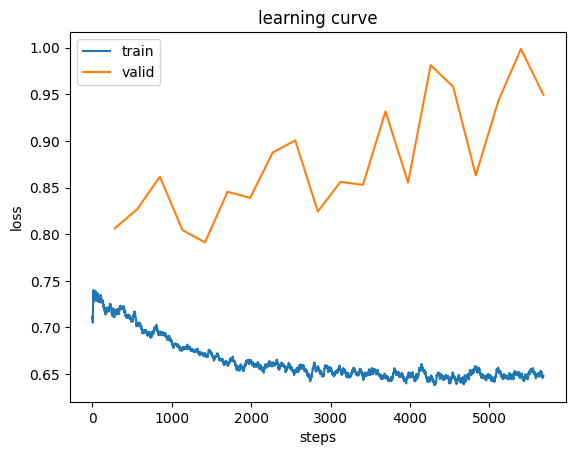

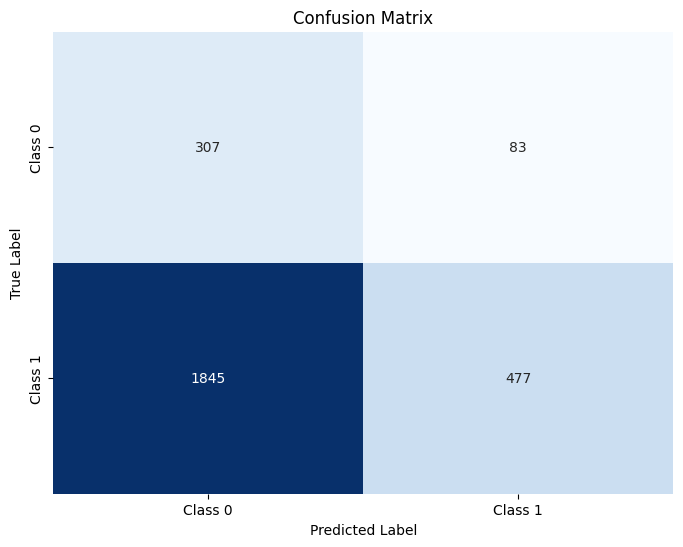

Accuracy: 0.2891
Precision: 0.8518
Recall: 0.2054
F1 Score: 0.3310
Average Precision (AP): 0.8225
Area Under ROC Curve (AUC): 0.3241


In [14]:
'''CLASS WEIGHTS'''
from tsai.models.ResNet import ResNet
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(2048, 2)  # 2048 channels from encoder, 2 output classes

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0 
)

model = FCMAEClassifier(encoder)
model.to(device)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted loss
loss_func = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Replace your loss function in the learner
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)
learn.fit_one_cycle(20, 1e-6)

learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")



Train label distribution:
  Term (0): 3360
  Preterm (1): 3360

Test label distribution:
  Term (0): 390
  Preterm (1): 390
torch.Size([6720])


epoch,train_loss,valid_loss,accuracy,time
0,0.693196,0.699394,0.444872,00:03
1,0.681961,0.685091,0.580769,00:03
2,0.671681,0.690618,0.574359,00:03
3,0.671389,0.691650,0.583333,00:03
4,0.666358,0.696499,0.567949,00:03
5,0.665009,0.698502,0.570513,00:03


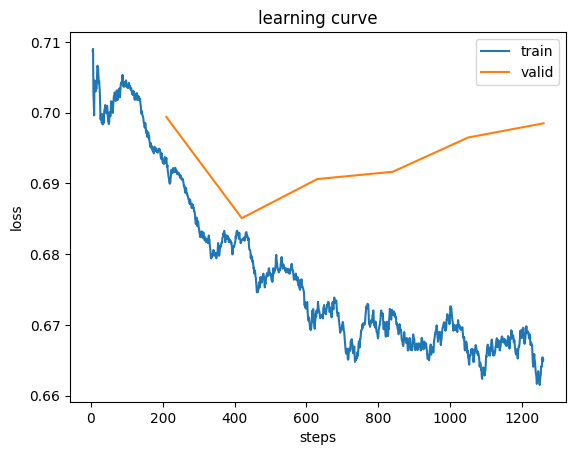

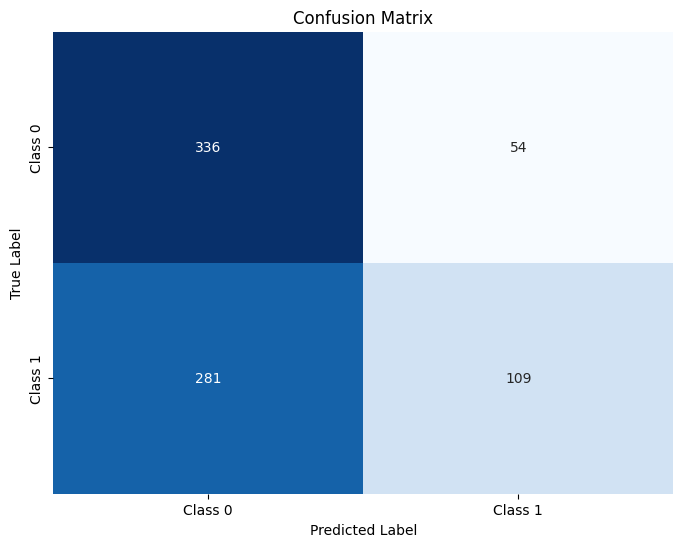

Accuracy: 0.5705
Precision: 0.6687
Recall: 0.2795
F1 Score: 0.3942
Average Precision (AP): 0.4815
Area Under ROC Curve (AUC): 0.3870


In [15]:
'''BALANCED DATA'''

from tsai.models.ResNet import ResNet
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

# Convert to numpy for easy indexing
train_windows = np.array(train_windows)
train_labels = np.array(train_labels)

# Get indices for each class
term_indices = np.where(train_labels == 0)[0]
preterm_indices = np.where(train_labels == 1)[0]

# Undersample the majority class (preterm) to match term
n_samples = min(len(term_indices), len(preterm_indices))
balanced_term_indices = np.random.choice(term_indices, n_samples, replace=False)
balanced_preterm_indices = np.random.choice(preterm_indices, n_samples, replace=False)

# Combine and shuffle
balanced_train_indices = np.concatenate([balanced_term_indices, balanced_preterm_indices])
np.random.shuffle(balanced_train_indices)

# Subset
train_windows_balanced = train_windows[balanced_train_indices]
train_labels_balanced = train_labels[balanced_train_indices]

test_windows = np.array(test_windows)
test_labels = np.array(test_labels)

term_indices = np.where(test_labels == 0)[0]
preterm_indices = np.where(test_labels == 1)[0]

n_samples = min(len(term_indices), len(preterm_indices))
balanced_term_indices = np.random.choice(term_indices, n_samples, replace=False)
balanced_preterm_indices = np.random.choice(preterm_indices, n_samples, replace=False)

balanced_test_indices = np.concatenate([balanced_term_indices, balanced_preterm_indices])
np.random.shuffle(balanced_test_indices)

test_windows_balanced = test_windows[balanced_test_indices]
test_labels_balanced = test_labels[balanced_test_indices]

train_windows = train_windows_balanced
train_labels = train_labels_balanced
test_windows = test_windows_balanced
test_labels = test_labels_balanced


# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)



# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32








class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(2048, 2)  # 2048 channels from encoder, 2 output classes

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0 
)

model = FCMAEClassifier(encoder)
model.to(device)

learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(6, 1e-6)

learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# Convert to numpy arrays if needed
true_labels = targs.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_probs = preds[:, 1].cpu().numpy()  # Probability of class 1

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
ap = average_precision_score(true_labels, pred_probs)
auc = roc_auc_score(true_labels, pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Area Under ROC Curve (AUC): {auc:.4f}")

